## 2.1. EEG/MEG Preprocessing Basics

**Purpose**: Clean raw data using filtering and ICA to improve the Signal-to-Noise Ratio (SNR). In this notebook, we move from raw, data to a cleaned signal ready for analysis. 

This notebook covers the essential steps for cleaning raw EEG/MEG data, which is highly susceptible to biological (e.g., eye blinks) and environmental (e.g., powerline hum) noise.

The goal of preprocessing is to improve the Signal-to-Noise Ratio (SNR) to ensure that subsequent analysis reflects true neural activity. We will cover:

- **Filtering**: Isolating desired frequency bands and removing narrow-band noise.

- **ICA Decomposition (Algorithm)**: Separating mixed sensor signals into independent components.

- **Artifact Removal**: Identifying and subtracting components linked to non-neural sources (e.g., EOG, ECG).

In [1]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from mne.datasets import sample

# Setup plotting backend
%matplotlib inline
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib', set_env=True)

Using matplotlib as 2D backend.


### 1. Data Acquisition

We download and load the MNE sample dataset. For preprocessing, it is helpful to keep the EOG (Electrooculogram) channels, as they record eye blinks which we will later remove using ICA.

In [2]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "meg_sample"
target_dir.mkdir(parents=True, exist_ok=True)

data_path = sample.data_path(path=str(target_dir), download=True)
meg_file = Path(data_path) / "MEG" / "sample" / "sample_audvis_raw.fif"

raw = mne.io.read_raw_fif(meg_file, preload=True)

# Pick MEG and EOG (eye) channels
raw.pick_types(meg=True, eeg=False, eog=True, stim=True)

print(f"Channels: {raw.ch_names[:5]}... and {raw.ch_names[-1]}")

Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channels: ['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']... and EOG 061


Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


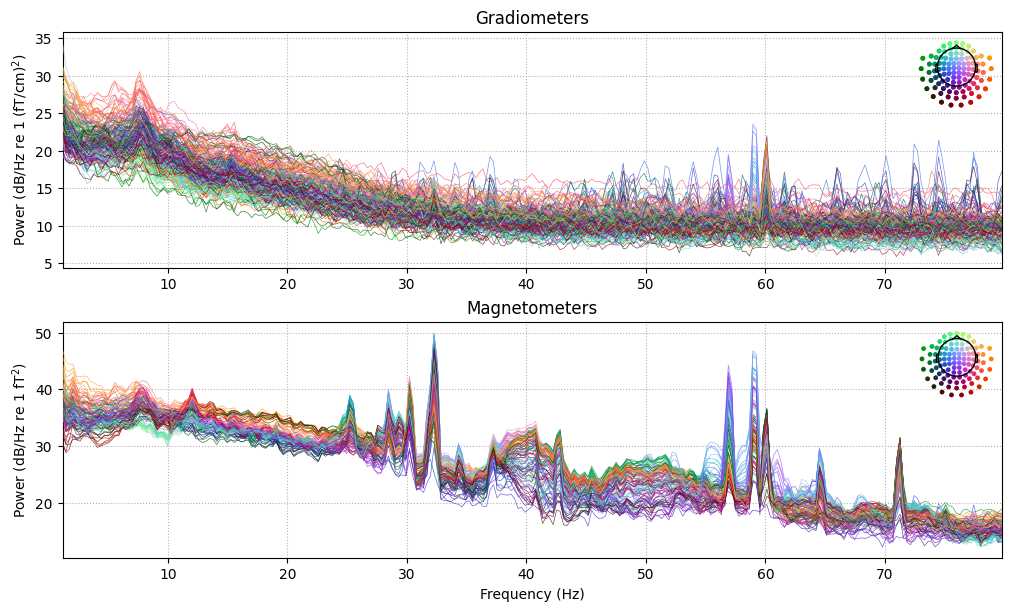

In [3]:
# Visualize the raw data PSD
raw.compute_psd(fmin=1, fmax=80).plot(picks="meg")
plt.show()

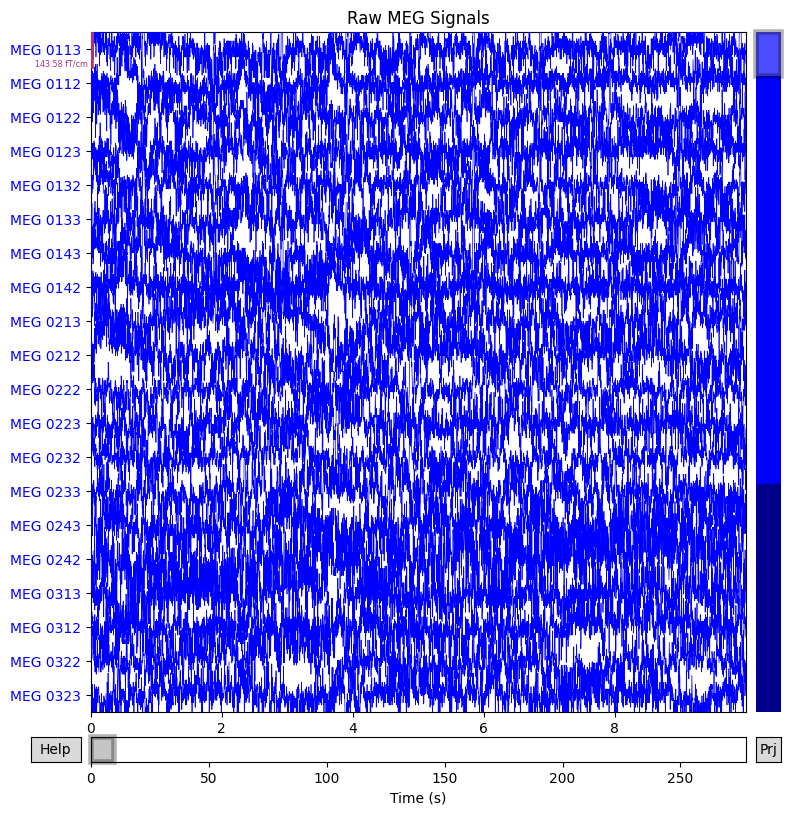

In [4]:
# Visualize raw MEG signals
fig = raw.plot(picks="meg", n_channels=20, scalings='auto', show=False)

ax = fig.axes[0] 
ax.set_title("Raw MEG Signals")

plt.show()

### 2. Filtering
Filtering is the first step in cleaning.
- **High-pass filter**: Removes slow drifts (e.g., electrode movement, perspiration).
- **Low-pass filter**: Removes high-frequency noise not related to brain activity.
- **Notch filter**: Removes specific power-line interference (50Hz or 60Hz).

#### Bandpass Filtering: Removing Artifacts at Frequency Extremes

A bandpass filter is defined by two cut-off frequencies: **a lower limit ($l\_freq$)** and an **upper limit ($h\_freq$)**. Signals between these limits are preserved (passed), while those outside are attenuated.
- **Low-Frequency (High-Pass)**: Removing noise below $l\_freq$ (e.g., 1 Hz). This eliminates slow, large-amplitude DC drifts caused by temperature changes, subject movement, or galvanic skin response (sweating). These artifacts severely skew spectral analysis.
- **High-Frequency (Low-Pass)**: Removing noise above $h\_freq$ (e.g., 40 Hz). This reduces high-frequency **muscle activity (EMG)** and systemic hardware/quantization noise, improving the overall smoothness of the signal.

#### Notch Filtering (Powerline Noise): Targeting Specific Frequencies

Powerline interference (the **AC hum**) is a predictable, sinusoidal noise source generated by electrical grids. It appears as a sharp spectral peak at:
- 50 Hz (most of Europe, Asia, Africa)
- 60 Hz (North and South America)

A **notch filter** is a highly specialized **band-stop filter** designed to create a deep, extremely **narrow attenuation** (the "notch") centered precisely at the target frequency (e.g., 50 Hz) and its harmonics (e.g., 100 Hz, 150 Hz).

This filter is essential because:

1. It removes the powerline contamination **without affecting nearby frequencies**, preserving underlying neural oscillations (e.g., preserving $\gamma$-band activity near 40 Hz).
2. By targeting only a tiny frequency range, it minimizes the loss of neural data that a wider, standard band-stop filter would cause.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edg

/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


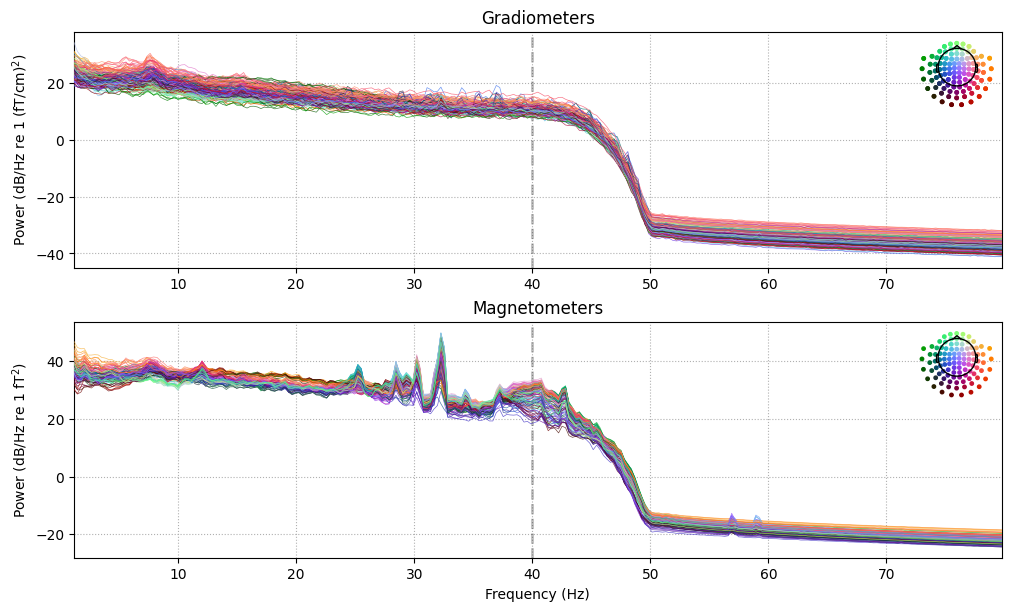

In [5]:
# 1. Band-pass filter between 1.0 and 40.0 Hz
raw.filter(l_freq=1.0, h_freq=40.0)

# 2. Notch filter to remove power line noise (specifically 60Hz for this dataset)
raw.notch_filter(freqs=60.0)

# Visualize the effect on the PSD
raw.compute_psd(fmin=1, fmax=80).plot(picks="meg")
plt.show()

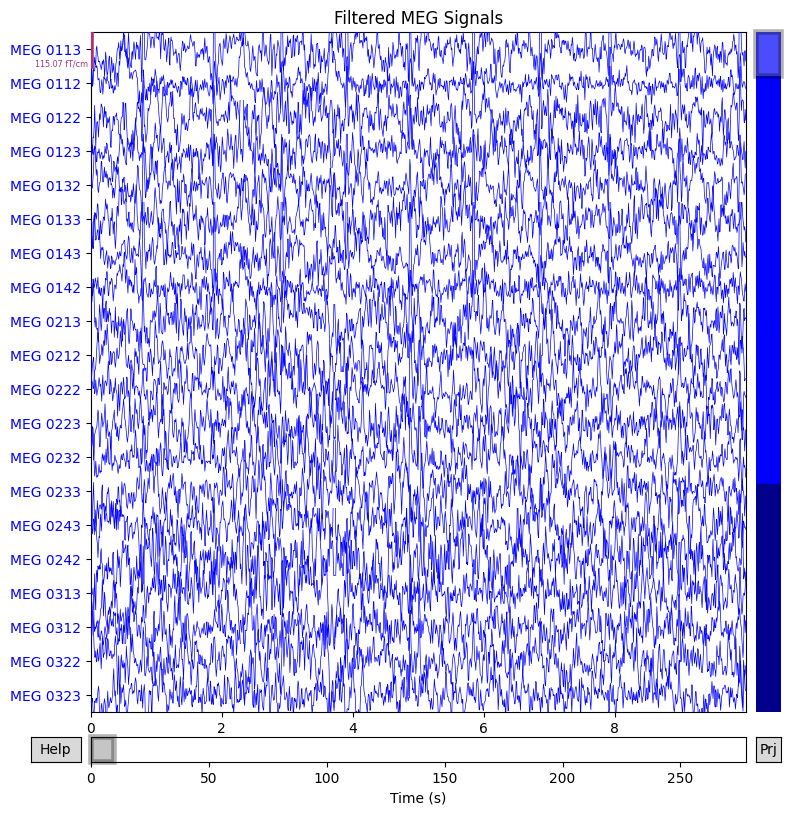

In [6]:
# Visualize filtered MEG signals
fig = raw.plot(picks="meg", n_channels=20, scalings='auto', show=False)

ax = fig.axes[0] 
ax.set_title("Filtered MEG Signals")

plt.show()

### 3. Artifact Detection (ICA)

**Independent Component Analysis (ICA)** is a blind source separation technique. It decomposes the mixed sensor signals into independent "components". Some components represent brain activity, while others represent noise (blinks, heartbeats). Unlike standard filtering, which works in the frequency domain, ICA works in the **time domain** to untangle superimposed signals.

The core assumption is that the signals measured at the sensors are a linear mixture of several **statistically independent source signals** (components) originating from different biological or non-biological processes.

**How it works**:
1. **Decomposition**: The algorithm (e.g., FastICA) computes a mixing matrix ($A$) and an unmixing matrix ($W$). It estimates independent components ($S$) such that the sensor data ($X$) is $X = A \cdot S$.
2. **Artifact Identification**: ICA is excellent at isolating artifacts because they often exhibit unique time courses and spatial patterns:
   - **Eye Blinks/Movements (EOG)**: Very large, sharp deflections focused on frontal electrodes.
   - **Heartbeat (ECG)**: Repetitive, pulsatile pattern localized near the heart/major arteries (especially in MEG).
   - **Muscle Artifacts (EMG)**: High-frequency, noisy patterns.
3. **Subtraction**: The component maps identified as artifacts are zeroed out.
4. **Reconstruction**: The remaining, cleaned components are mixed back together to create the artifact-free sensor data.

In [7]:
# We use 20 components and a fixed random state for reproducibility
ica = mne.preprocessing.ICA(n_components=20, random_state=42, method='fastica')

# We exclude the EOG channels from the fitting process itself
ica.fit(raw, picks="meg")

print("ICA fitting complete.")

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.4s.
ICA fitting complete.


### 4. Identifying and Removing Artifacts

We use the EOG channel as a template to find which ICA components correlate with eye blinks.


In [8]:
# Find components that correlate with eye blinks (EOG)
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='EOG 061')

print(f"Automatically identified EOG components: {eog_indices}")

Using EOG channel: EOG 061
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz

What to look for in a valid blink component:
- **Topomap**: A strong, circular "blob" right over the eyes/forehead.
- **Time course**: Sharp, high-amplitude spikes that look like heartbeats but are spaced further apart (actual blinks).
- **Power Spectrum**: A smooth curve that stays high in the low frequencies (1–4Hz) and tapers off.

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_18321/2047159888.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


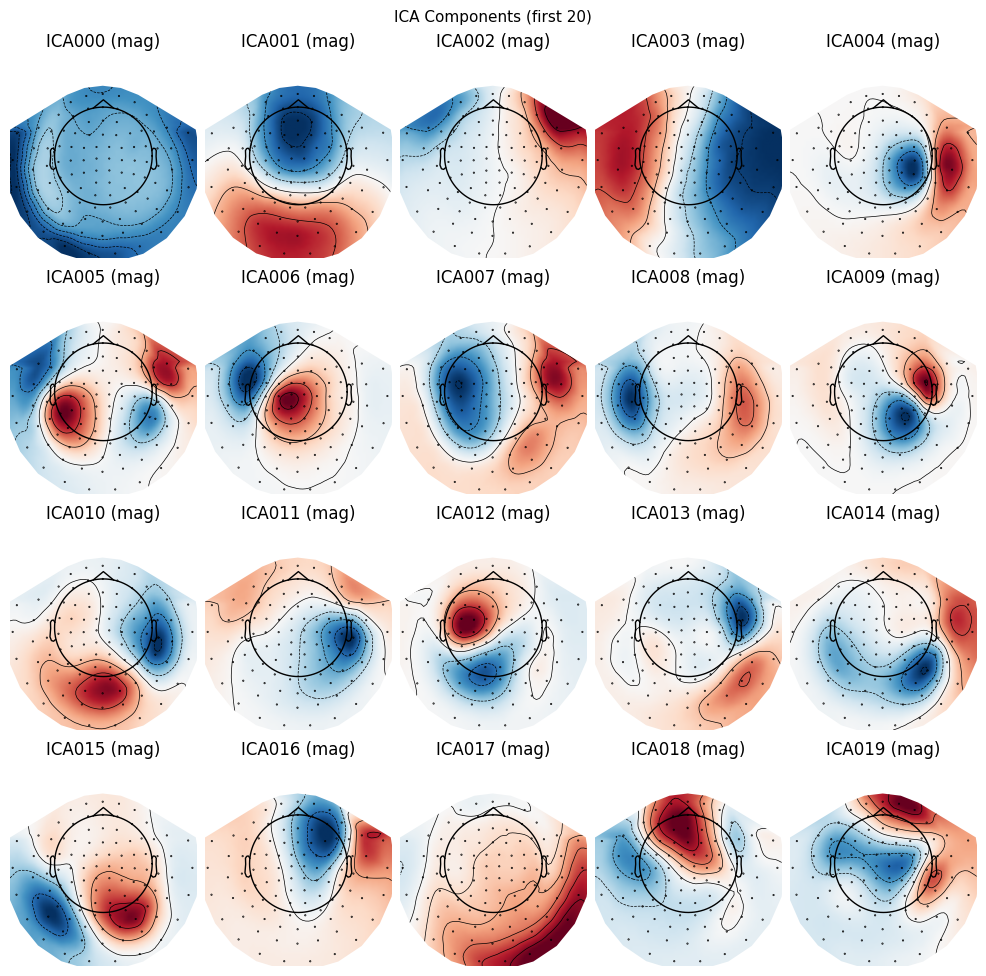

In [9]:
fig = ica.plot_components(picks=range(20), show=False)
fig.suptitle("ICA Components (first 20)", fontsize=11)
fig.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


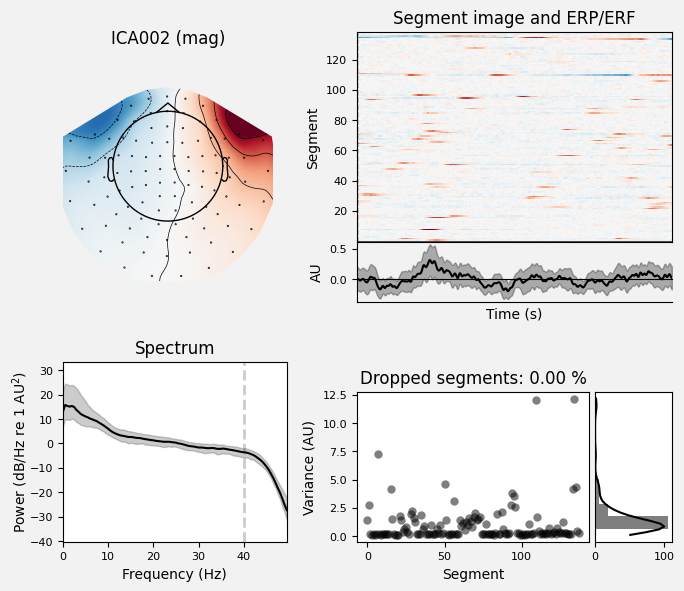

[<Figure size 700x600 with 6 Axes>]

In [10]:
# Visualize the identified component's properties
ica.plot_properties(raw, picks=eog_indices)

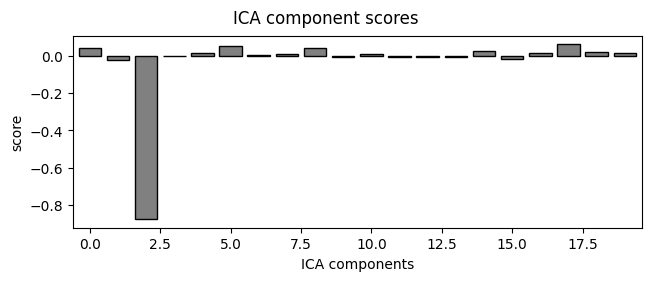

In [11]:
# Visualize the 'scores' to see how strongly each component matches the EOG
ica.plot_scores(eog_scores)
plt.show()

### 5. Applying The Correction

Once we are confident the identified components are artifacts, we "exclude" them and reconstruct the raw signal.

In [12]:
# Set the identified components for exclusion
ica.exclude = eog_indices

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 305 PCA components


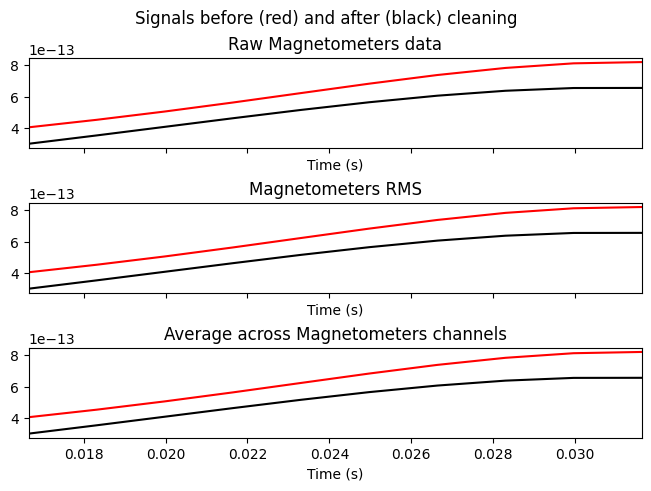

In [13]:
# Validating the Cleaning
# We pick a frontal sensor ('MEG 0121') where blinks are loudest
ica.plot_overlay(raw, picks=['MEG 0121'], start=10, stop=20)
plt.show()

In [14]:
# Apply the ICA exclusion to a copy of the data
raw_cleaned = raw.copy()
ica.apply(raw_cleaned)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 305 PCA components


<Raw | sample_audvis_raw.fif, 315 x 166800 (277.7 s), ~404.0 MiB, data loaded>

### 7. Quantitative Verification

To see the actual impact of the ICA, we compare the "Before" and "After" on the same scale, or look at the "Residual" (what was actually subtracted).

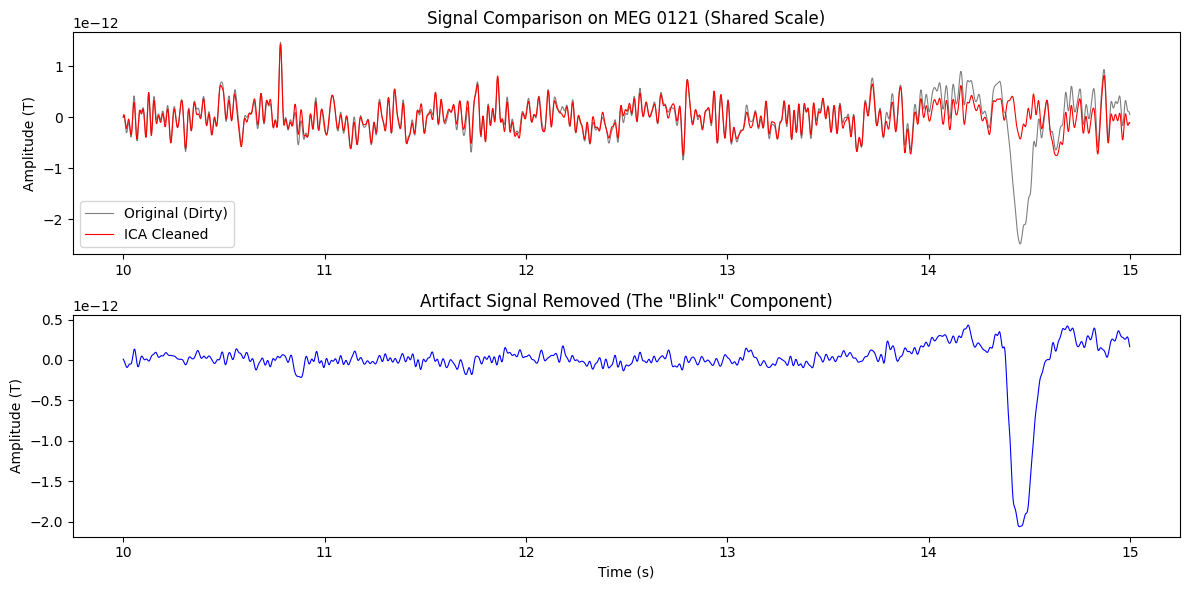

In [15]:
# Select a frontal channel and a time window with a blink
ch_name = 'MEG 0121' 
t_start, t_stop = 10, 15

# Extract data arrays
start_samp = int(t_start * raw.info['sfreq'])
stop_samp = int(t_stop * raw.info['sfreq'])
data_orig, times = raw[ch_name, start_samp:stop_samp]
data_clean, _ = raw_cleaned[ch_name, start_samp:stop_samp]

# Plotting
plt.figure(figsize=(12, 6))

# Subplot 1: Overlay (Cleaned vs Original)
plt.subplot(2, 1, 1)
plt.plot(times, data_orig[0], color='gray', linewidth=0.8, label='Original (Dirty)')
plt.plot(times, data_clean[0], color='red', linewidth=0.8, label='ICA Cleaned')
plt.title(f'Signal Comparison on {ch_name} (Shared Scale)')
plt.ylabel('Amplitude (T)')
plt.legend()

# Subplot 2: The Residual (The "Blink" itself)
# This is exactly what ICA subtracted from the signal
plt.subplot(2, 1, 2)
plt.plot(times, data_orig[0] - data_clean[0], linewidth=0.8, color='blue')
plt.title('Artifact Signal Removed (The "Blink" Component)')
plt.ylabel('Amplitude (T)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()